# Vega Lite Examples in Haskell - Interactive

The overview notebook - `VegaLiteGallery` - describes how 
[`hvega`](http://hackage.haskell.org/package/hvega)
is used to create Vega-Lite visualizations.

-----

## Table of Contents

This notebook represents the [Interactive](https://vega.github.io/vega-lite/examples/#interactive)
section of the [Vega-Lite example gallery](https://vega.github.io/vega-lite/examples/).

### Interactive Charts

 - [Bar Chart with Highlighting on Hover and Selection on Click](#Bar-Chart-with-Highlighting-on-Hover-and-Selection-on-Click)
 - [Scatterplot with External Links and Tooltips](#Scatterplot-with-External-Links-and-Tooltips)
 - [Rectangular Brush](#Rectangular-Brush)
 - [Area Chart with Rectangular Brush](#Area-Chart-with-Rectangular-Brush)
 - [Paintbrush Highlight](#Paintbrush-Highlight)
 - [Scatterplot Pan and Zoom](#Scatterplot-Pan-and-Zoom)
 - [Query Widgets](#Query-Widgets)
 - [Interactive Average](#Interactive-Average)
 - [Multi Series Line Chart with Labels](#Multi-Series-Line-Chart-with-Labels)
 - [Multi Series Line Chart with Tooltip](#Multi-Series-Line-Chart-with-Tooltip)
 - [Isotype Grid](#Isotype-Grid)
 - [Brushing Scatter Plot to show data on a table](#Brushing-Scatter-Plot-to-show-data-on-a-table)
 - [Selectable Heatmap](#Selectable-Heatmap)
 - [Bar Chart with a Minimap](#Bar-Chart-with-a-Minimap)

### Interactive Multi-View Displays

 - [Overview and Detail](#Overview-and-Detail)
 - [Crossfilter](#Crossfilter)
 - [Interactive Scatterplot Matrix](#Interactive-Scatterplot-Matrix)
 - [Interactive Dashboard with Cross Highlight](#Interactive-Dashboard-with-Cross-Highlight)
 - [Seattle Weather ExplorationTOC](#Seattle-Weather-Exploration)
 - [Connections among Major U.S. Airports](#Connections-among-Major-U.S.-Airports)

---

## Versions

The notebook was last run with the following versions of [`hvega`](https://hackage.haskell.org/package/hvega) and
related modules:

In [1]:
:!ghc-pkg latest ghc
:!ghc-pkg latest ihaskell
:!ghc-pkg latest hvega
:!ghc-pkg latest ihaskell-hvega

ghc-8.4.4

ihaskell-0.9.1.0

hvega-0.4.0.0

ihaskell-hvega-0.2.0.3

As to when it was last run, how about:

In [2]:
import Data.Time (getCurrentTime)
getCurrentTime

2019-09-04 12:53:49.722557786 UTC

## Set up

See the overview notebook for an explanation of this section (it provides code I use to compare the `hvega` output
to the specification given in the Vega-Lite gallery).

In [3]:
{-# LANGUAGE OverloadedStrings #-}

-- VegaLite uses these names
import Prelude hiding (filter, lookup, repeat)

import Graphics.Vega.VegaLite

-- IHaskell automatically imports this if the `ihaskell-vega` module is installed
-- import IHaskell.Display.Hvega

-- If you are viewing this in an IHaskell notebook rather than Jupyter Lab,
-- use the following to see the visualizations
--
-- vlShow = id

In [4]:
{-# LANGUAGE QuasiQuotes #-}

import qualified Data.ByteString.Lazy.Char8 as BL8
import qualified Data.HashMap.Strict as HM
import qualified Data.Set as S

import Data.Aeson (Value(Object), encode)
import Data.Aeson.QQ.Simple (aesonQQ)
import Control.Monad (forM_, unless, when)
import Data.Maybe (fromJust)
import System.Directory (removeFile)
import System.Process (readProcess, readProcessWithExitCode)

validate ::
  VLSpec       -- ^ The expected specification
  -> VegaLite  -- ^ The actual visualization
  -> IO ()
validate exp vl = 
  let got = fromVL vl
      put = putStrLn
  in if got == exp
      then put "Okay"
      else do
        let red = "\x1b[31m"
            def = "\x1b[0m"
            
            report m = put (red ++ m ++ def)
            
        report "The visualization and expected specification do not match."
        
        -- assume both objects
        let Object oexp = exp
            Object ogot = got
            kexp = S.fromList (HM.keys oexp)
            kgot = S.fromList (HM.keys ogot)
            kmiss = S.toList (S.difference kexp kgot)
            kextra = S.toList (S.difference kgot kexp)
            keys = S.toList (S.intersection kexp kgot)
            
        unless (null kmiss && null kextra) $ do
          put ""
          report "Keys are different:"
          unless (null kmiss)  $ put ("  Missing: " ++ show kmiss)
          unless (null kextra) $ put ("  Extra  : " ++ show kextra)

        -- this often creates an impressive amount of text for what is
        -- only a small change, which is why it is followed by a call
        -- to debug
        --
        forM_ keys $ \key ->
          let vexp = fromJust (HM.lookup key oexp)
              vgot = fromJust (HM.lookup key ogot)
          in when (vexp /= vgot) $ do
            put ""
            report ("Values are different for " ++ show key)
            put ("  Expected: " ++ show vexp)
            put ("  Found   : " ++ show vgot)
          
        putStrLn ""
        report "The field-level differences are:"
        debug_ exp vl


-- Rather than come up with a way to diff JSON here, rely on `jq` and the trusty
-- `diff` command. This is not written to be robust!
--
debug_ spec vl = do
  let tostr = BL8.unpack . encode
  
  expected <- readProcess "jq" [] (tostr spec)
  got <- readProcess "jq" [] (tostr (fromVL vl))

  let f1 = "expected.json"
      f2 = "got.json"
      
  writeFile f1 expected
  writeFile f2 got
  
  let diffOpts = ["--minimal", f1, f2]
  (_, diff, _) <- readProcessWithExitCode "diff" diffOpts ""
  putStrLn diff
  
  forM_ [f1, f2] removeFile

---

## Interactive Charts

 - [Bar Chart with Highlighting on Hover and Selection on Click](#Bar-Chart-with-Highlighting-on-Hover-and-Selection-on-Click)
 - [Scatterplot with External Links and Tooltips](#Scatterplot-with-External-Links-and-Tooltips)
 - [Rectangular Brush](#Rectangular-Brush)
 - [Area Chart with Rectangular Brush](#Area-Chart-with-Rectangular-Brush)
 - [Paintbrush Highlight](#Paintbrush-Highlight)
 - [Scatterplot Pan and Zoom](#Scatterplot-Pan-and-Zoom)
 - [Query Widgets](#Query-Widgets)
 - [Interactive Average](#Interactive-Average)
 - [Multi Series Line Chart with Labels](#Multi-Series-Line-Chart-with-Labels)
 - [Multi Series Line Chart with Tooltip](#Multi-Series-Line-Chart-with-Tooltip)
 - [Isotype Grid](#Isotype-Grid)
 - [Brushing Scatter Plot to show data on a table](#Brushing-Scatter-Plot-to-show-data-on-a-table)
 - [Selectable Heatmap](#Selectable-Heatmap)
 - [Bar Chart with a Minimap](#Bar-Chart-with-a-Minimap)
 
---

### Bar Chart with Highlighting on Hover and Selection on Click

From https://vega.github.io/vega-lite/examples/interactive_bar_select_highlight.html

In [5]:
interactiveBarSelectHighlightSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "A bar chart with highlighting on hover and selecting on click. (Inspired by Tableau's interaction style.)",
  "data": {
    "values": [
      {"a": "A", "b": 28}, {"a": "B", "b": 55}, {"a": "C", "b": 43},
      {"a": "D", "b": 91}, {"a": "E", "b": 81}, {"a": "F", "b": 53},
      {"a": "G", "b": 19}, {"a": "H", "b": 87}, {"a": "I", "b": 52}
    ]
  },
  "selection": {
    "highlight": {"type": "single", "empty": "none", "on": "mouseover"},
    "select": {"type": "multi"}
  },
  "mark": {
    "type": "bar",
    "fill": "#4C78A8",
    "stroke": "black",
    "cursor": "pointer"
  },
  "encoding": {
    "x": {"field": "a", "type": "ordinal"},
    "y": {"field": "b", "type": "quantitative"},
    "fillOpacity": {
      "condition": {"selection": "select", "value": 1},
      "value": 0.3
    },
    "strokeWidth": {
      "condition": [
        {
          "test": {
            "and": [
              {"selection": "select"},
              "length(data(\"select_store\"))"
            ]
          },
          "value": 2
        },
        {"selection": "highlight", "value": 1}
      ],
      "value": 0
    }
  },
  "config": {
    "scale": {
      "bandPaddingInner": 0.2
    }
  }
}
|]

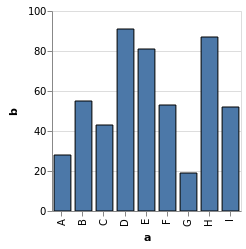

In [6]:
interactiveBarSelectHighlight =
    let labels = description "A bar chart with highlighting on hover and selecting on click. (Inspired by Tableau's interaction style.)"

        dvals = dataFromColumns []
                  . dataColumn "a" (Strings ["A", "B", "C", "D", "E", "F", "G", "H", "I"])
                  . dataColumn "b" (Numbers [28, 55, 43, 91, 81, 53, 19, 87, 52])

        sel = selection
                . select "highlight" Single [Empty, On "mouseover"]
                . select "select" Multi []
                
        selCond = MSelectionCondition (SelectionName "select")
                                      [MNumber 1] [MNumber 0.3]
        strokeCond = MDataCondition
                       [ (And (Selection "select") (Expr "length(data(\"select_store\"))")
                          , [MNumber 2])
                       , (Selection "highlight"
                         , [MNumber 1])
                       ]
                       [MNumber 0]
        enc = encoding
                . position X [PName "a", PmType Ordinal]
                . position Y [PName "b", PmType Quantitative]
                . fillOpacity [selCond]
                . strokeWidth [strokeCond]
                
        markOpts = mark Bar [MFill "#4C78A8", MStroke "black", MCursor CPointer]
        cnf = configure (configuration (Scale [SCBandPaddingInner 0.2]) [])

    in toVegaLite [labels, cnf, dvals [], sel [], markOpts, enc []]

vlShow interactiveBarSelectHighlight

In [7]:
validate interactiveBarSelectHighlightSpec interactiveBarSelectHighlight

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Scatterplot with External Links and Tooltips

From https://vega.github.io/vega-lite/examples/point_href.html

In [8]:
pointHrefSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "A scatterplot showing horsepower and miles per gallons that opens a Google search for the car that you click on.",
  "data": {"url": "data/cars.json"},
  "mark": "point",
  "transform": [{
    "calculate": "'https://www.google.com/search?q=' + datum.Name", "as": "url"
  }],
  "encoding": {
    "x": {"field": "Horsepower", "type": "quantitative"},
    "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
    "color": {"field": "Origin", "type": "nominal"},
    "tooltip": {"field": "Name", "type": "nominal"},
    "href": {"field": "url", "type": "nominal"}
  }
}
|]

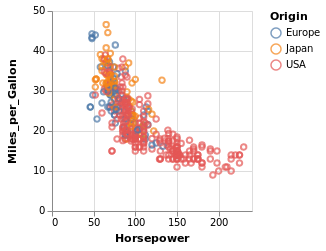

In [9]:
pointHref =
    let labels = description "A scatterplot showing horsepower and miles per gallons that opens a Google search for the car that you click on."
        dvals = dataFromUrl "data/cars.json" []
        
        trans = transform
                  . calculateAs "'https://www.google.com/search?q=' + datum.Name" "url"
                  
        enc = encoding
                . position X [PName "Horsepower", PmType Quantitative]
                . position Y [PName "Miles_per_Gallon", PmType Quantitative]
                . color [MName "Origin", MmType Nominal]
                . tooltip [TName "Name", TmType Nominal]
                . hyperlink [HName "url", HmType Nominal]
                
    in toVegaLite [labels, dvals, mark Point [], trans [], enc []]
    
vlShow pointHref

In [10]:
validate pointHrefSpec pointHref

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Rectangular Brush

From https://vega.github.io/vega-lite/examples/interactive_brush.html

In [11]:
interactiveBrushSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Drag out a rectangular brush to highlight points.",
  "data": {"url": "data/cars.json"},
  "selection": {
    "brush": {
      "type": "interval",
      "init": {"x": [55, 160], "y": [13, 37]}
    }
  },
  "mark": "point",
  "encoding": {
    "x": {"field": "Horsepower", "type": "quantitative"},
    "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
    "color": {
      "condition": {"selection": "brush", "field": "Cylinders", "type": "ordinal"},
      "value": "grey"
    }
  }
}
|]

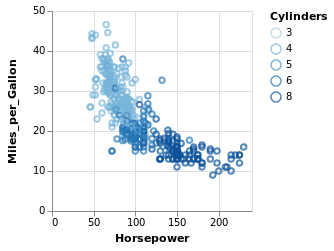

In [12]:
interactiveBrush =
    let labels = description "Drag out a rectangular brush to highlight points."
        dvals = dataFromUrl "data/cars.json" []
        
        xvals = (Number 55, Number 160)
        yvals = (Number 13, Number 37)
        sel = selection
                (select "brush" Interval [SInitInterval (Just xvals) (Just yvals)] [])
    
        enc = encoding
                . position X [PName "Horsepower", PmType Quantitative]
                . position Y [PName "Miles_per_Gallon", PmType Quantitative]
                . color [MSelectionCondition (SelectionName "brush")
                                             [MName "Cylinders", MmType Ordinal]
                                             [MString "grey"]
                        ]

    in toVegaLite [labels, dvals, sel, mark Point [], enc []]
    
vlShow interactiveBrush

In [13]:
validate interactiveBrushSpec interactiveBrush

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Area Chart with Rectangular Brush

From https://vega.github.io/vega-lite/examples/interactive_area_brush.html

In [14]:
interactiveAreaBrushSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/unemployment-across-industries.json"},
  "encoding": {
      "x": {"timeUnit": "yearmonth", "field": "date", "type": "temporal"},
      "y": {"aggregate": "sum", "field": "count", "type": "quantitative"}
  },
  "layer": [{
    "selection": {
      "brush": {
        "type": "interval",
        "encodings": ["x"]
      }
    },
    "mark": "area"
  }, {
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "mark": {"type": "area", "color": "goldenrod"}
  }]
}
|]

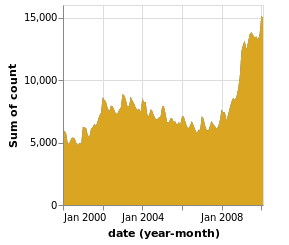

In [15]:
interactiveAreaBrush =
    let dvals = dataFromUrl "data/unemployment-across-industries.json" []
        enc = encoding
                . position X [PName "date", PmType Temporal, PTimeUnit YearMonth]
                . position Y [PName "count", PmType Quantitative, PAggregate Sum]
                
        sel1 = selection (select "brush" Interval [Encodings [ChX]] [])
        trans2 = transform (filter (FSelection "brush") [])
        lyr1 = [sel1, mark Area []]
        lyr2 = [trans2, mark Area [MColor "goldenrod"]]
        lyr = map asSpec [lyr1, lyr2]
        
    in toVegaLite [dvals, enc [], layer lyr]

vlShow interactiveAreaBrush

In [16]:
validate interactiveAreaBrushSpec interactiveAreaBrush

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Paintbrush Highlight

From https://vega.github.io/vega-lite/examples/interactive_paintbrush.html

In [17]:
interactivePaintbrushSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Select multiple points with the shift key.",
  "data": {"url": "data/cars.json"},
  "selection": {
    "paintbrush": {
      "type": "multi", "on": "mouseover",
      "nearest": true
    }
  },
  "mark": "point",
  "encoding": {
    "x": {"field": "Horsepower", "type": "quantitative"},
    "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
    "size": {
      "condition": {"selection": "paintbrush", "value": 300},
      "value": 50
    }
  }
}
|]

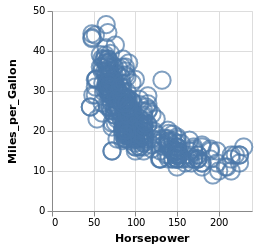

In [18]:
interactivePaintbrush =
    let labels = description "Select multiple points with the shift key."
        dvals = dataFromUrl "data/cars.json" []
        sel = selection (select "paintbrush" Multi [On "mouseover", Nearest True] [])
    
        enc = encoding
                . position X [PName "Horsepower", PmType Quantitative]
                . position Y [PName "Miles_per_Gallon", PmType Quantitative]
                . size [MSelectionCondition (SelectionName "paintbrush") [MNumber 300] [MNumber 50]]
                
    in toVegaLite [labels, dvals, sel, mark Point [], enc []]
    
vlShow interactivePaintbrush

In [19]:
validate interactivePaintbrushSpec interactivePaintbrush

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Scatterplot Pan and Zoom

From https://vega.github.io/vega-lite/examples/selection_translate_scatterplot_drag.html

In [20]:
selectionTranslateScatterplotDragSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/cars.json"},
  "selection": {
    "grid": {
      "type": "interval", "bind": "scales"
    }
  },
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "Horsepower", "type": "quantitative",
      "scale": {"domain": [75, 150]}
    },
    "y": {
      "field": "Miles_per_Gallon", "type": "quantitative",
      "scale": {"domain": [20, 40]}
    },
    "size": {"field": "Cylinders", "type": "quantitative"}
  }
}
|]

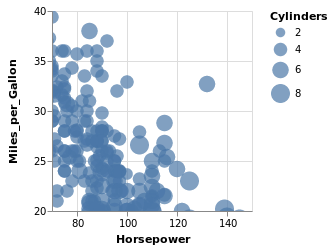

In [21]:
selectionTranslateScatterplotDrag =
    let dvals = dataFromUrl "data/cars.json" []
        sel = selection (select "grid" Interval [BindScales] [])
    
        enc = encoding
                . position X [PName "Horsepower", PmType Quantitative, PScale [SDomain (DNumbers [75, 150])]]
                . position Y [PName "Miles_per_Gallon", PmType Quantitative, PScale [SDomain (DNumbers [20, 40])]]
                . size [MName "Cylinders", MmType Quantitative]
                
    in toVegaLite [dvals, sel, mark Circle [], enc []]
    
vlShow selectionTranslateScatterplotDrag

In [22]:
validate selectionTranslateScatterplotDragSpec selectionTranslateScatterplotDrag

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Query Widgets

From https://vega.github.io/vega-lite/examples/interactive_query_widgets.html

In [23]:
interactiveQueryWidgetsSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Drag the sliders to highlight points.",
  "data": {"url": "data/cars.json"},
  "transform": [{"calculate": "year(datum.Year)", "as": "Year"}],
  "layer": [{
    "selection": {
      "CylYr": {
        "type": "single", "fields": ["Cylinders", "Year"],
        "init": {"Cylinders": 4, "Year": 1977},
        "bind": {
          "Cylinders": {"input": "range", "min": 3, "max": 8, "step": 1},
          "Year": {"input": "range", "min": 1969, "max": 1981, "step": 1}
        }
      }
    },
    "mark": "circle",
    "encoding": {
      "x": {"field": "Horsepower", "type": "quantitative"},
      "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
      "color": {
        "condition": {"selection": "CylYr", "field": "Origin", "type": "nominal"},
        "value": "grey"
      }
    }
  }, {
    "transform": [{"filter": {"selection": "CylYr"}}],
    "mark": "circle",
    "encoding": {
      "x": {"field": "Horsepower", "type": "quantitative"},
      "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
      "color": {"field": "Origin", "type": "nominal"},
      "size": {"value": 100}
    }
  }]
}
|]

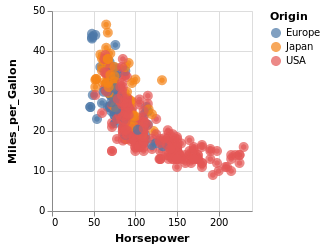

In [24]:
interactiveQueryWidgets =
    let labels = description "Drag the sliders to highlight points."
        dvals = dataFromUrl "data/cars.json" []
        trans = transform (calculateAs "year(datum.Year)" "Year" [])
        
        xpos = position X [PName "Horsepower", PmType Quantitative]
        ypos =  position Y [PName "Miles_per_Gallon", PmType Quantitative]
        
        
        sel1 = selection
                 . select "CylYr" Single
                          [ Fields ["Cylinders", "Year"]
                          , SInit [ ("Cylinders", Number 4), ("Year", Number 1977)]
                          , Bind
                              [ IRange "Cylinders" [ InMin 3, InMax 8, InStep 1 ]
                              , IRange "Year" [ InMin 1969, InMax 1981, InStep 1 ]
                              ]
                          ]
                          
        enc1 = encoding
                 . xpos
                 . ypos
                 . color [MSelectionCondition (SelectionName "CylYr")
                                              [MName "Origin", MmType Nominal]
                                              [MString "grey"]]
                 
        trans2 = transform (filter (FSelection "CylYr") [])
        enc2 = encoding
                 . xpos
                 . ypos
                 . color [MName "Origin", MmType Nominal]
                 . size [MNumber 100]
                 
        lyr1 = [sel1 [], mark Circle [], enc1 []]
        lyr2 = [trans2, mark Circle [], enc2 []]
        lyrs = map asSpec [lyr1, lyr2]
        
    in toVegaLite [labels, dvals, trans, layer lyrs]
    
vlShow interactiveQueryWidgets

In [25]:
validate interactiveQueryWidgetsSpec interactiveQueryWidgets

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Interactive Average

From https://vega.github.io/vega-lite/examples/selection_layer_bar_month.html

In [26]:
selectionLayerBarMonthSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/seattle-weather.csv"},
  "layer": [{
    "selection": {
      "brush": {
        "type": "interval",
        "encodings": ["x"]
      }
    },
    "mark": "bar",
    "encoding": {
      "x": {
        "timeUnit": "month",
        "field": "date",
        "type": "ordinal"
      },
      "y": {
        "aggregate": "mean",
        "field": "precipitation",
        "type": "quantitative"
      },
      "opacity": {
        "condition": {
          "selection": "brush", "value": 1
        },
        "value": 0.7
      }
    }
  }, {
    "transform": [{
      "filter": {"selection": "brush"}
    }],
    "mark": "rule",
    "encoding": {
      "y": {
        "aggregate": "mean",
        "field": "precipitation",
        "type": "quantitative"
      },
      "color": {"value": "firebrick"},
      "size": {"value": 3}
    }
  }]
}
|]

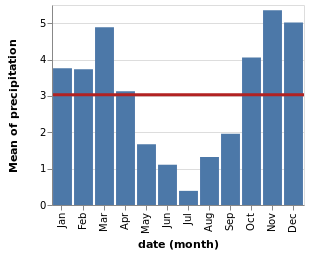

In [27]:
selectionLayerBarMonth =
    let dvals = dataFromUrl "data/seattle-weather.csv" []
    
        sel1 = selection (select "brush" Interval [Encodings [ChX]] [])
        
        ypos = position Y [PAggregate Mean, PName "precipitation", PmType Quantitative]

        enc1 = encoding
                 . position X [PName "date", PmType Ordinal, PTimeUnit Month]
                 . ypos
                 . opacity [ MSelectionCondition (SelectionName "brush")
                                                 [MNumber 1]
                                                 [MNumber 0.7]
                           ]

        trans2 = transform (filter (FSelection "brush") [])
        enc2 = encoding
                  . ypos
                  . color [MString "firebrick"]
                  . size [MNumber 3]
                  
        lyr1 = [sel1, mark Bar [], enc1 []]
        lyr2 = [trans2, mark Rule [], enc2 []]
        
        lyrs = map asSpec [lyr1, lyr2]
    in toVegaLite [dvals, layer lyrs]
    
vlShow selectionLayerBarMonth

In [28]:
validate selectionLayerBarMonthSpec selectionLayerBarMonth

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Multi Series Line Chart with Labels

From https://vega.github.io/vega-lite/examples/interactive_multi_line_label.html

In [29]:
interactiveMultiLineLabelSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "url": "data/stocks.csv",
    "format": {
      "type": "csv",
      "parse": {
        "date": "date"
      }
    }
  },
  "width": 800,
  "height": 400,
  "layer": [
    {
      "encoding": {
        "x": {"field": "date", "type": "temporal"},
        "y": {"field": "price", "type": "quantitative"},
        "color": {"field": "symbol", "type": "nominal"}
      },
      "layer": [{
        "mark": "line"
      },{
        "selection": {
          "label": {
            "type": "single",
            "nearest": true,
            "on": "mouseover",
            "encodings": [
              "x"
            ],
            "empty": "none"
          }
        },
        "mark": "point",
        "encoding": {
          "opacity": {
            "condition": {
              "selection": "label",
              "value": 1
            },
            "value": 0
          }
        }
      }]
    },
    {
      "transform": [
        {
          "filter": {
            "selection": "label"
          }
        }
      ],
      "layer": [{
        "mark": {
         "type": "rule",
         "color": "gray"
        },
        "encoding": {
          "x": {
            "type": "temporal",
            "field": "date"
          }
        }
      }, {
        "encoding": {
          "text": {
            "type": "quantitative",
            "field": "price"
          },
          "x": {
            "type": "temporal",
            "field": "date"
          },
          "y": {
            "type": "quantitative",
            "field": "price"
          }
        },
        "layer": [{
          "mark": {
            "type": "text",
            "stroke": "white",
            "strokeWidth": 2,
            "align": "left",
            "dx": 5,
            "dy": -5
          }
        }, {
          "mark": {
            "type": "text",
            "align": "left",
            "dx": 5,
            "dy": -5
          },
          "encoding": {
            "color": {
              "type": "nominal",
              "field": "symbol",
              "legend": null
            }
          }
        }]
      }]
   }
 ]
}
|]

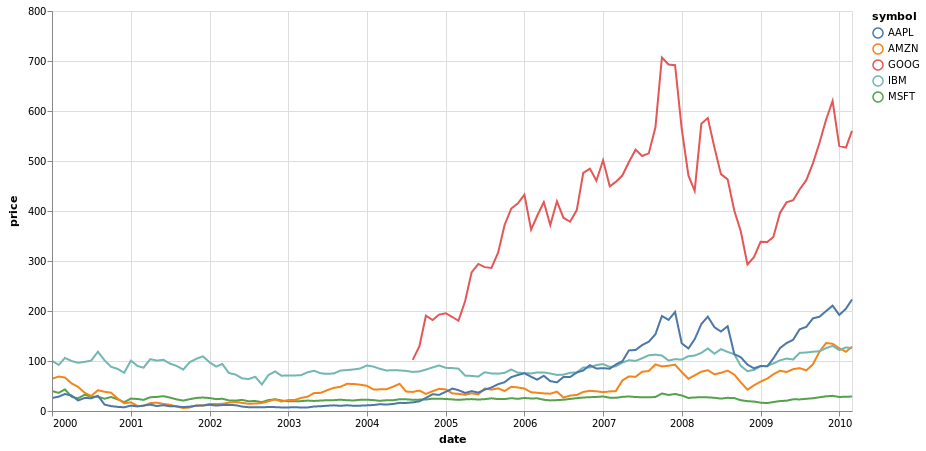

In [30]:
interactiveMultiLineLabel =
    let dvals = dataFromUrl "data/stocks.csv" [CSV, Parse [("date", FoDate "")]]
           
        enc = encoding
                 . position X [PName "date", PmType Temporal]
                 . position Y [PName "price", PmType Quantitative]
                 . color [MName "symbol", MmType Nominal]

        enc12 = encoding
                   . opacity [ MSelectionCondition (SelectionName "label")
                               [MNumber 1] [MNumber 0]
                             ]
           
        lyr11 = [mark Line []]
        lyr12 = [sel12 [], mark Point [], enc12 []]
        lyrs1 = map asSpec [lyr11, lyr12]
        lyr1 = [enc [], layer lyrs1]
        
        sel12 = selection
                   . select "label" Single [Nearest True, On "mouseover", Empty, Encodings [ChX]]
           
        trans2 = transform
                    . filter (FSelection "label")
        
        posX = position X [PName "date", PmType Temporal]
        enc21 = encoding
                   . posX
        enc22 = encoding
                   . posX
                   . position Y [PName "price", PmType Quantitative]
                   . text [TName "price", TmType Quantitative]

        encb = encoding . color [MName "symbol", MmType Nominal, MLegend []]

        lyr21 = [mark Rule [MColor "gray"], enc21 []]
        
        lyra = [mark Text [MStroke "white", MStrokeWidth 2, MAlign AlignLeft, MdX 5, MdY (-5)]]
        lyrb = [mark Text [MAlign AlignLeft, MdX 5, MdY (-5)], encb []]
        lyrs22 = map asSpec [lyra, lyrb]
        
        lyr22 = [enc22 [], layer lyrs22]
        lyrs2 = map asSpec [lyr21, lyr22]
        
        lyr2 = [trans2 [], layer lyrs2]
        lyrs = map asSpec [lyr1, lyr2]
           
    in toVegaLite [dvals, width 800, height 400, layer lyrs]
       
vlShow interactiveMultiLineLabel

In [31]:
validate interactiveMultiLineLabelSpec interactiveMultiLineLabel

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Multi Series Line Chart with Tooltip

From https://vega.github.io/vega-lite/examples/interactive_multi_line_tooltip.html

In [32]:
interactiveMultiLineTooltipSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/seattle-weather.csv", "format": {"type": "csv"}},
  "encoding": {
    "x": {"timeUnit": "yearmonthdate", "field": "date", "type": "temporal"},
    "tooltip": [
      {"timeUnit": "yearmonthdate", "field": "date", "type": "temporal"},
      {"field": "temp_max", "type": "quantitative"},
      {"field": "temp_min", "type": "quantitative"}
    ]
  },
  "layer": [{
    "mark": {"type": "line", "color": "orange"},
    "encoding": {
      "y": {"field": "temp_max", "type": "quantitative"}
    }
  }, {
    "mark": {"type": "line", "color": "red"},
    "encoding": {
      "y": {"field": "temp_min", "type": "quantitative"}
    }
  }, {
    "mark": "rule",
    "selection": {
      "hover": {"type": "single", "on": "mouseover", "empty": "none"}
    },
    "encoding": {
      "color": {
        "condition":{
          "selection": {"not": "hover"}, "value": "transparent"
        }
      }
    }
  }],
  "config": {"axisY": {"minExtent": 30}}
}
|]

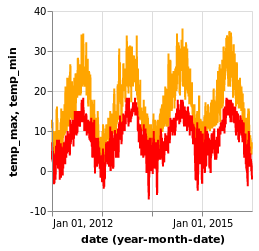

In [33]:
interactiveMultiLineTooltip =
    let config = configure (configuration (AxisY [MinExtent 30]) [])
        dvals = dataFromUrl "data/seattle-weather.csv" [CSV]

        ypos name = position Y [PName name, PmType Quantitative]

        enc = encoding
                . position X [PName "date", PmType Temporal, PTimeUnit YearMonthDate]
                . tooltips [ [TName "date", TmType Temporal, TTimeUnit YearMonthDate]
                           , [TName "temp_max", TmType Quantitative]
                           , [TName "temp_min", TmType Quantitative]
                           ]

        enc1 = encoding (ypos "temp_max" [])
        enc2 = encoding (ypos "temp_min" [])
 
        lyr1 = [mark Line [ MColor "orange" ], enc1]
        lyr2 = [mark Line [ MColor "red" ], enc2]

        sel = selection
                . select "hover" Single [On "mouseover", Empty]

        enc3 = encoding
                 . color [ MSelectionCondition (Not (SelectionName "hover"))
                                               [MString "transparent"]
                                               []
                         ]

        lyr3 = [sel [], mark Rule [], enc3 []]
        lyrs = map asSpec [lyr1, lyr2, lyr3]
        
    in toVegaLite [config, dvals, enc [], layer lyrs]

    
vlShow interactiveMultiLineTooltip

In [34]:
validate interactiveMultiLineTooltipSpec interactiveMultiLineTooltip

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Isotype Grid

From https://vega.github.io/vega-lite/examples/isotype_grid.html

In [35]:
isotopeGridSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "config": {"view": {"stroke": ""}},
  "width": 400,
  "height": 400,
  "data": {
    "values": [
      {"id": 1},
      {"id": 2},
      {"id": 3},
      {"id": 4},
      {"id": 5},
      {"id": 6},
      {"id": 7},
      {"id": 8},
      {"id": 9},
      {"id": 10},
      {"id": 11},
      {"id": 12},
      {"id": 13},
      {"id": 14},
      {"id": 15},
      {"id": 16},
      {"id": 17},
      {"id": 18},
      {"id": 19},
      {"id": 20},
      {"id": 21},
      {"id": 22},
      {"id": 23},
      {"id": 24},
      {"id": 25},
      {"id": 26},
      {"id": 27},
      {"id": 28},
      {"id": 29},
      {"id": 30},
      {"id": 31},
      {"id": 32},
      {"id": 33},
      {"id": 34},
      {"id": 35},
      {"id": 36},
      {"id": 37},
      {"id": 38},
      {"id": 39},
      {"id": 40},
      {"id": 41},
      {"id": 42},
      {"id": 43},
      {"id": 44},
      {"id": 45},
      {"id": 46},
      {"id": 47},
      {"id": 48},
      {"id": 49},
      {"id": 50},
      {"id": 51},
      {"id": 52},
      {"id": 53},
      {"id": 54},
      {"id": 55},
      {"id": 56},
      {"id": 57},
      {"id": 58},
      {"id": 59},
      {"id": 60},
      {"id": 61},
      {"id": 62},
      {"id": 63},
      {"id": 64},
      {"id": 65},
      {"id": 66},
      {"id": 67},
      {"id": 68},
      {"id": 69},
      {"id": 70},
      {"id": 71},
      {"id": 72},
      {"id": 73},
      {"id": 74},
      {"id": 75},
      {"id": 76},
      {"id": 77},
      {"id": 78},
      {"id": 79},
      {"id": 80},
      {"id": 81},
      {"id": 82},
      {"id": 83},
      {"id": 84},
      {"id": 85},
      {"id": 86},
      {"id": 87},
      {"id": 88},
      {"id": 89},
      {"id": 90},
      {"id": 91},
      {"id": 92},
      {"id": 93},
      {"id": 94},
      {"id": 95},
      {"id": 96},
      {"id": 97},
      {"id": 98},
      {"id": 99},
      {"id": 100}
    ]
  },
  "transform": [
    {"calculate": "ceil (datum.id/10)", "as": "col"},
    {"calculate": "datum.id - datum.col*10", "as": "row"}
  ],
  "mark": {"type": "point", "filled": true},
  "encoding": {
    "x": {"field": "col", "type": "ordinal", "axis": null},
    "y": {"field": "row", "type": "ordinal", "axis": null},
    "shape": {
      "value": "M1.7 -1.7h-0.8c0.3 -0.2 0.6 -0.5 0.6 -0.9c0 -0.6 -0.4 -1 -1 -1c-0.6 0 -1 0.4 -1 1c0 0.4 0.2 0.7 0.6 0.9h-0.8c-0.4 0 -0.7 0.3 -0.7 0.6v1.9c0 0.3 0.3 0.6 0.6 0.6h0.2c0 0 0 0.1 0 0.1v1.9c0 0.3 0.2 0.6 0.3 0.6h1.3c0.2 0 0.3 -0.3 0.3 -0.6v-1.8c0 0 0 -0.1 0 -0.1h0.2c0.3 0 0.6 -0.3 0.6 -0.6v-2c0.2 -0.3 -0.1 -0.6 -0.4 -0.6z"
    },
    "color": {
      "condition": {"selection": "highlight", "value": "rgb(194,81,64)"},
      "value": "rgb(167,165,156)"
    },
    "size": {"value": 90}
  },
  "selection": {"highlight": {"type": "interval"}}
}
|]

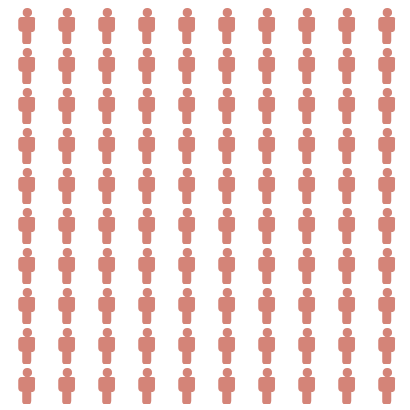

In [36]:
isotopeGrid =
    let dvals = dataFromColumns [] (dataColumn "id" (Numbers [1..100]) [])
        config = configure (configuration (View [ViewStroke (Just "")]) [])
        
        trans = transform
                  . calculateAs "ceil (datum.id/10)" "col"
                  . calculateAs "datum.id - datum.col*10" "row"

        person = "M1.7 -1.7h-0.8c0.3 -0.2 0.6 -0.5 0.6 -0.9c0 -0.6 -0.4 -1 -1 -1c-0.6 0 -1 0.4 -1 1c0 0.4 0.2 0.7 0.6 0.9h-0.8c-0.4 0 -0.7 0.3 -0.7 0.6v1.9c0 0.3 0.3 0.6 0.6 0.6h0.2c0 0 0 0.1 0 0.1v1.9c0 0.3 0.2 0.6 0.3 0.6h1.3c0.2 0 0.3 -0.3 0.3 -0.6v-1.8c0 0 0 -0.1 0 -0.1h0.2c0.3 0 0.6 -0.3 0.6 -0.6v-2c0.2 -0.3 -0.1 -0.6 -0.4 -0.6z"

        pos dir name = position dir [PName name, PmType Ordinal, PAxis []]
        enc = encoding
                . pos X "col"
                . pos Y "row"
                . shape [MString person]
                . color [MSelectionCondition (SelectionName "highlight") [MString "rgb(194,81,64)"] [MString "rgb(167,165,156)"]]
                . size [MNumber 90]
                
        markOpts = mark Point [MFilled True]
        sel = selection (select "highlight" Interval [] [])

    in toVegaLite [dvals, config, height 400, width 400, enc [], markOpts, sel, trans []]

vlShow isotopeGrid

In [37]:
validate isotopeGridSpec isotopeGrid

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Brushing Scatter Plot to show data on a table

From https://vega.github.io/vega-lite/examples/brush_table.html

In [38]:
brushTableSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "Drag a rectangular brush to show (first 20) selected points in a table.",
  "data": {"url": "data/cars.json"},
  "transform": [{
    "window": [{"op": "row_number", "as": "row_number"}]
  }],
  "hconcat": [{
    "selection": {
      "brush": {
        "type": "interval"
      }
    },
    "mark": "point",
    "encoding": {
      "x": {"field": "Horsepower", "type": "quantitative"},
      "y": {"field": "Miles_per_Gallon", "type": "quantitative"},
      "color": {
        "condition": {"selection": "brush", "field": "Cylinders", "type": "ordinal"},
        "value": "grey"
      }
    }
  }, {
    "transform": [
      {"filter": {"selection": "brush"}},
      {"window": [{"op": "rank", "as": "rank"}]},
      {"filter": {"field": "rank", "lt": 20}}
    ],
    "hconcat": [{
      "width": 50,
      "title": "Horsepower",
      "mark": "text",
      "encoding": {
        "text": {"field": "Horsepower", "type": "nominal"},
        "y": {"field": "row_number", "type": "ordinal", "axis": null}
      }
    }, {
      "width": 50,
      "title": "MPG",
      "mark": "text",
      "encoding": {
        "text": {"field": "Miles_per_Gallon", "type": "nominal"},
        "y": {"field": "row_number", "type": "ordinal", "axis": null}
      }
    }, {
      "width": 50,
      "title": "Origin",
      "mark": "text",
      "encoding": {
        "text": {"field": "Origin", "type": "nominal"},
        "y": {"field": "row_number", "type": "ordinal", "axis": null}
      }
    }]
  }],
  "resolve": {
    "legend": {
      "color": "independent"
    }
  }
}
|]

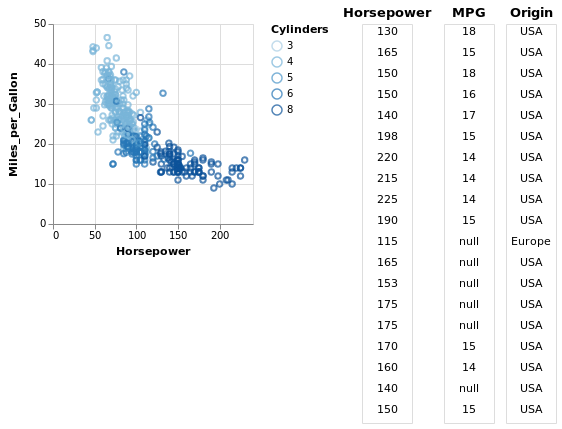

In [39]:
brushTable =
    let desc = description "Drag a rectangular brush to show (first 20) selected points in a table."
        dvals = dataFromUrl "data/cars.json" []
        trans = transform (window [([WOp RowNumber], "row_number")] [] [])
        rslv = resolve (resolution (RLegend [(ChColor, Independent)]) [])

        pos axis name = position axis [PName name, PmType Quantitative]

        sel1 = selection (select "brush" Interval [] [])
        enc1 = encoding
                 . pos X "Horsepower"
                 . pos Y "Miles_per_Gallon"
                 . color [MSelectionCondition (SelectionName "brush")
                                              [MName "Cylinders", MmType Ordinal]
                                              [MString "grey"]
                         ]
        lyr1 = [sel1, mark Point [], enc1 []]

        trans2 = transform
                   . filter (FSelection "brush")
                   . window [([WOp Rank], "rank")] []
                   . filter (FLessThan "rank" (Number 20))
                   
        enct name = encoding
                      . text [TName name, TmType Nominal]
                      . position Y [PName "row_number", PmType Ordinal, PAxis []]

        tbl1 = [width 50, title "Horsepower" [], mark Text [], enct "Horsepower" []]
        tbl2 = [width 50, title "MPG" [], mark Text [], enct "Miles_per_Gallon" []]
        tbl3 = [width 50, title "Origin" [], mark Text [], enct "Origin" []]
        
        tables = map asSpec [tbl1, tbl2, tbl3]
        lyr2 = [trans2 [], hConcat tables]

        layers = map asSpec [lyr1, lyr2]
        
    in toVegaLite [desc, dvals, trans, rslv, hConcat layers]
    
vlShow brushTable

In [40]:
validate brushTableSpec brushTable

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Selectable Heatmap

From https://vega.github.io/vega-lite/examples/selection_heatmap.html

This example has no schema specification, and the configuration is handled differently, 
so the comparison between the `hvega` output and the specification will report differences,
but this should not change the visualization or its behavior.

In [41]:
selectionHeatmapSpec = [aesonQQ|
{
  "data": {
    "values": [
      {"actual": "A", "predicted": "A", "count": 13},
      {"actual": "A", "predicted": "B", "count": 0},
      {"actual": "A", "predicted": "C", "count": 0},
      {"actual": "B", "predicted": "A", "count": 0},
      {"actual": "B", "predicted": "B", "count": 10},
      {"actual": "B", "predicted": "C", "count": 6},
      {"actual": "C", "predicted": "A", "count": 0},
      {"actual": "C", "predicted": "B", "count": 0},
      {"actual": "C", "predicted": "C", "count": 9}
    ]
  },
  "selection": {
    "highlight": {"type": "single"}
  },
  "mark": "bar",
  "encoding": {
    "y": {
      "field": "actual",
      "type": "nominal"
    },
    "x": {
      "field": "predicted",
      "type": "nominal"
    },
    "color": {
      "field": "count",
      "type": "quantitative"
    },
    "opacity": {
      "condition": {"selection": "highlight", "value": 1},
      "value": 0.5
    }
  },
  "config": {
    "scale": {
      "bandPaddingInner": 0,
      "bandPaddingOuter": 0
    },
    "view": {"step": 40},
    "range": {
      "ramp": {
        "scheme": "yellowgreenblue"
      }
    }
  }
}
|]

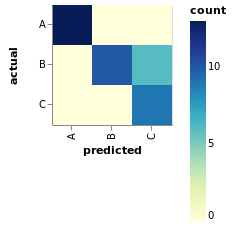

In [42]:
selectionHeatmap =
    let config = configure
                   . configuration (Scale [SCBandPaddingInner 0, SCBandPaddingOuter 0, SCRangeStep (Just 40)])
                   . configuration (Range [RRamp "yellowgreenblue"])
               
        dvals = dataFromColumns []
                   . dataColumn "actual" (Strings ["A", "A", "A", "B", "B", "B", "C", "C", "C"])
                   . dataColumn "predicted" (Strings ["A", "B", "C", "A", "B", "C", "A", "B", "C"])
                   . dataColumn "count" (Numbers [13, 0, 0, 0, 10, 6, 0, 0, 9])
        
        sel = selection (select "highlight" Single [] [])
        
        enc = encoding
                . position Y [PName "actual", PmType Nominal]
                . position X [PName "predicted", PmType Nominal]
                . color [MName "count", MmType Quantitative]
                . opacity [MSelectionCondition (SelectionName "highlight")
                                               [MNumber 1] [MNumber 0.5]]
        
    in toVegaLite [config [], dvals [], sel, mark Bar [], enc []]
    
vlShow selectionHeatmap

In [43]:
validate selectionHeatmapSpec selectionHeatmap

The visualization and expected specification do not match.

Keys are different:
  Extra  : ["$schema"]

Values are different for "config"
  Expected: Object (fromList [("scale",Object (fromList [("bandPaddingInner",Number 0.0),("bandPaddingOuter",Number 0.0)])),("range",Object (fromList [("ramp",Object (fromList [("scheme",String "yellowgreenblue")]))])),("view",Object (fromList [("step",Number 40.0)]))])
  Found   : Object (fromList [("scale",Object (fromList [("rangeStep",Number 40.0),("bandPaddingInner",Number 0.0),("bandPaddingOuter",Number 0.0)])),("range",Object (fromList [("ramp",Object (fromList [("scheme",String "yellowgreenblue")]))]))])

The field-level differences are:
3a4
>       "rangeStep": 40,
11,13d11
<     },
<     "view": {
<       "step": 40
65a64
>   "$schema": "https://vega.github.io/schema/vega-lite/v3.json",

Return to the [Table of Contents](#Table-of-Contents).

### Bar Chart with a Minimap

From https://vega.github.io/vega-lite/examples/bar_count_minimap.html

I have chosen to follow the specification that is shown in the
[Vega On-line Editor](https://vega.github.io/editor/#/examples/vega-lite/bar_count_minimap) for
this example, rather than the specification below (the difference is how `"sort": "-x"`
is encoded).

In [44]:
barCountMinimapSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/cars.json"},
  "hconcat": [{
    "mark": "bar",
    "encoding": {
      "y": {
        "field": "Name",
        "type": "nominal",
        "scale": {"domain": {"selection": "brush"}},
        "axis": {"minExtent": 200, "title": null},
        "sort": "-x"
      },
      "x": {
        "aggregate": "count",
        "type": "quantitative",
        "scale":{"domain":  [0, 6]},
        "axis": {"orient": "top"}
      }
    }
  }, {
    "height": 200,
    "width": 50,
    "selection": {
      "brush": {
        "type": "interval",
        "encodings": ["y"]
      }
    },
    "mark": "bar",
    "encoding": {
      "y": {
        "field": "Name",
        "type": "nominal",
        "sort": "-x",
        "axis": null
      },
      "x": {
        "aggregate": "count",
        "type": "quantitative",
        "axis": null
      }
    }
  }]
}
|]

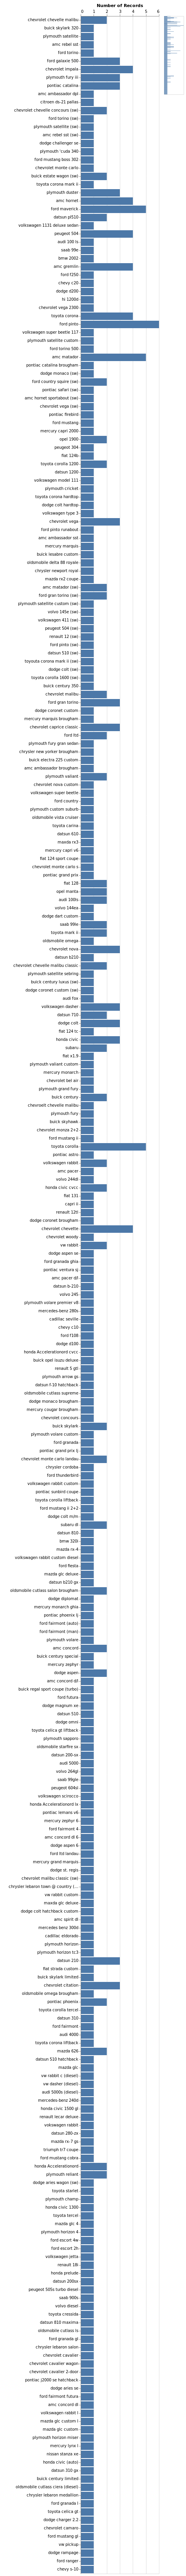

In [45]:
barCountMinimap =
    let dvals = dataFromUrl "data/cars.json" []
    
        xpos extra = position X ([PAggregate Count, PmType Quantitative] ++ extra)
        ypos extra = position Y ([PName "Name", PmType Nominal, PSort [ByChannel ChX, Descending]] ++ extra)
    
        enc1 = encoding
                 . ypos [PScale [SDomain (DSelection "brush")], PAxis [AxMinExtent 200, AxNoTitle]]
                 . xpos [PScale [SDomain (DNumbers [0, 6])], PAxis [AxOrient STop]]
                 
        mainLayer = [mark Bar [], enc1 []]
        
        sel2 = selection (select "brush" Interval [Encodings [ChY]] [])
        enc2 = encoding
                 . ypos [PAxis []]
                 . xpos [PAxis []]
                 
        overviewLayer = [height 200, width 50, sel2, mark Bar [], enc2 []]
        
        layers = map asSpec [mainLayer, overviewLayer]
    in toVegaLite [dvals, hConcat layers]
    
vlShow barCountMinimap

In [46]:
validate barCountMinimapSpec barCountMinimap

The visualization and expected specification do not match.

Values are different for "hconcat"
  Expected: Array [Object (fromList [("mark",String "bar"),("encoding",Object (fromList [("x",Object (fromList [("scale",Object (fromList [("domain",Array [Number 0.0,Number 6.0])])),("aggregate",String "count"),("type",String "quantitative"),("axis",Object (fromList [("orient",String "top")]))])),("y",Object (fromList [("field",String "Name"),("scale",Object (fromList [("domain",Object (fromList [("selection",String "brush")]))])),("sort",String "-x"),("type",String "nominal"),("axis",Object (fromList [("minExtent",Number 200.0),("title",Null)]))]))]))]),Object (fromList [("height",Number 200.0),("mark",String "bar"),("width",Number 50.0),("selection",Object (fromList [("brush",Object (fromList [("encodings",Array [String "y"]),("type",String "interval")]))])),("encoding",Object (fromList [("x",Object (fromList [("aggregate",String "count"),("type",String "quantitative"),("axis",Null)])),("y

Return to the [Table of Contents](#Table-of-Contents).

---

## Interactive Multi-View Displays

 - [Overview and Detail](#Overview-and-Detail)
 - [Crossfilter](#Crossfilter)
 - [Interactive Scatterplot Matrix](#Interactive-Scatterplot-Matrix)
 - [Interactive Dashboard with Cross Highlight](#Interactive-Dashboard-with-Cross-Highlight)
 - [Seattle Weather ExplorationTOC](#Seattle-Weather-Exploration)
 - [Connections among Major U.S. Airports](#Connections-among-major-U.S.-Airports)

---

### Overview and Detail

From https://vega.github.io/vega-lite/examples/interactive_overview_detail.html

In [47]:
interactiveOverviewDetailSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {"url": "data/sp500.csv"},
  "vconcat": [{
    "width": 480,
    "mark": "area",
    "encoding": {
      "x": {
        "field": "date",
        "type": "temporal",
        "scale": {"domain": {"selection": "brush"}},
        "axis": {"title": ""}
      },
      "y": {"field": "price", "type": "quantitative"}
    }
  }, {
    "width": 480,
    "height": 60,
    "mark": "area",
    "selection": {
      "brush": {"type": "interval", "encodings": ["x"]}
    },
    "encoding": {
      "x": {
        "field": "date",
        "type": "temporal"
      },
      "y": {
        "field": "price",
        "type": "quantitative",
        "axis": {"tickCount": 3, "grid": false}
      }
    }
  }]
}
|]

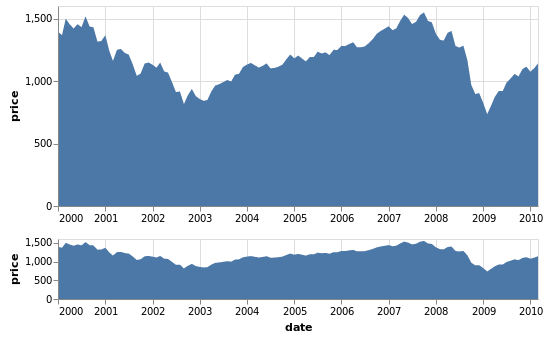

In [48]:
interactiveOverviewDetail =
    let dvals = dataFromUrl "data/sp500.csv" []
    
        w = width 480
    
        xpos extra = position X ([PName "date", PmType Temporal] ++ extra)
        ypos extra = position Y ([PName "price", PmType Quantitative] ++ extra)
        
        enc1 = encoding
                 . xpos [PScale [SDomain (DSelection "brush")], PAxis [AxTitle ""]]
                 . ypos []
        enc2 = encoding
                 . xpos []
                 . ypos [PAxis [AxTickCount 3, AxGrid False]]

        sel2 = selection (select "brush" Interval [Encodings [ChX]] [])
        lyr1 = [w, mark Area [], enc1 []]
        lyr2 = [w, height 60, mark Area [], enc2 [], sel2]
        layers = map asSpec [lyr1, lyr2]
        
    in toVegaLite [dvals, vConcat layers]
    
vlShow interactiveOverviewDetail

In [49]:
validate interactiveOverviewDetailSpec interactiveOverviewDetail

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Crossfilter

From https://vega.github.io/vega-lite/examples/interactive_layered_crossfilter.html

In [50]:
interactiveLayeredCrossfilterSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "data": {
    "url": "data/flights-2k.json",
    "format": {"parse": {"date": "date"}}
  },
  "transform": [{"calculate": "hours(datum.date)", "as": "time"}],
  "repeat": {"column": ["distance", "delay", "time"]},
  "spec": {
    "layer": [{
      "selection": {
        "brush": {"type": "interval", "encodings": ["x"]}
      },
      "mark": "bar",
      "encoding": {
        "x": {
          "field": {"repeat": "column"},
          "bin": {"maxbins": 20},
          "type": "quantitative"
        },
        "y": {"aggregate": "count", "type": "quantitative"},
        "color": {"value": "#ddd"}
      }
    }, {
      "transform": [{"filter": {"selection": "brush"}}],
      "mark": "bar",
      "encoding": {
        "x": {
          "field": {"repeat": "column"},
          "bin": {"maxbins": 20},
          "type": "quantitative"
        },
        "y": {"aggregate": "count", "type": "quantitative"}
      }
    }]
  }
}
|] 

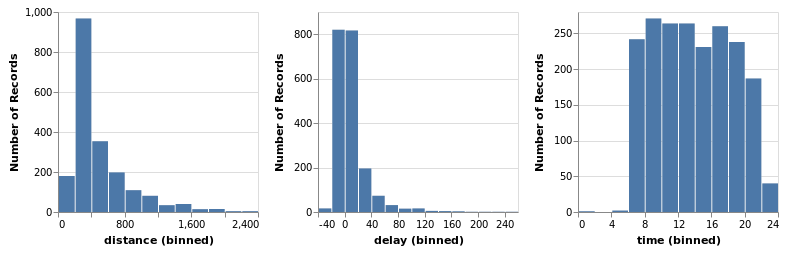

In [51]:
interactiveLayeredCrossfilter =
    let dvals = dataFromUrl "data/flights-2k.json" [Parse [("date", FoDate "")]]
        trans = transform (calculateAs "hours(datum.date)" "time" [])
        rpt = repeat [ColumnFields ["distance", "delay", "time"]]
        
        enc extra = encoding
                      . position X [PRepeat Column, PmType Quantitative, PBin [MaxBins 20]]
                      . position Y [PAggregate Count, PmType Quantitative]
                      . extra

        sel1 = selection (select "brush" Interval [Encodings [ChX]] [])
        trans2 = transform (filter (FSelection "brush") [])
        
        lyr1 = [sel1, mark Bar [], enc (color [MString "#ddd"]) []]
        lyr2 = [trans2, mark Bar [], enc id []]
        layers = layer (map asSpec [lyr1, lyr2])
        
    in toVegaLite [dvals, trans, rpt, specification (asSpec [layers])]
    
vlShow interactiveLayeredCrossfilter

In [52]:
validate interactiveLayeredCrossfilterSpec interactiveLayeredCrossfilter

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Interactive Scatterplot Matrix

From https://vega.github.io/vega-lite/examples/interactive_splom.html

In [53]:
interactiveSplomSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "repeat": {
    "row": ["Horsepower", "Acceleration", "Miles_per_Gallon"],
    "column": ["Miles_per_Gallon", "Acceleration", "Horsepower"]
  },
  "spec": {
    "data": {"url": "data/cars.json"},
    "mark": "point",
    "selection": {
      "brush": {
        "type": "interval",
        "resolve": "union",
        "on": "[mousedown[event.shiftKey], window:mouseup] > window:mousemove!",
        "translate": "[mousedown[event.shiftKey], window:mouseup] > window:mousemove!",
        "zoom": "wheel![event.shiftKey]"
      },
      "grid": {
        "type": "interval",
        "resolve": "global",
        "bind": "scales",
        "translate": "[mousedown[!event.shiftKey], window:mouseup] > window:mousemove!",
        "zoom": "wheel![!event.shiftKey]"
      }
    },
    "encoding": {
      "x": {"field": {"repeat": "column"}, "type": "quantitative"},
      "y": {
        "field": {"repeat": "row"},
        "type": "quantitative",
        "axis": {"minExtent": 30}
      },
      "color": {
        "condition": {
          "selection": "brush",
          "field": "Origin",
          "type": "nominal"
        },
        "value": "grey"
      }
    }
  }
}
|]

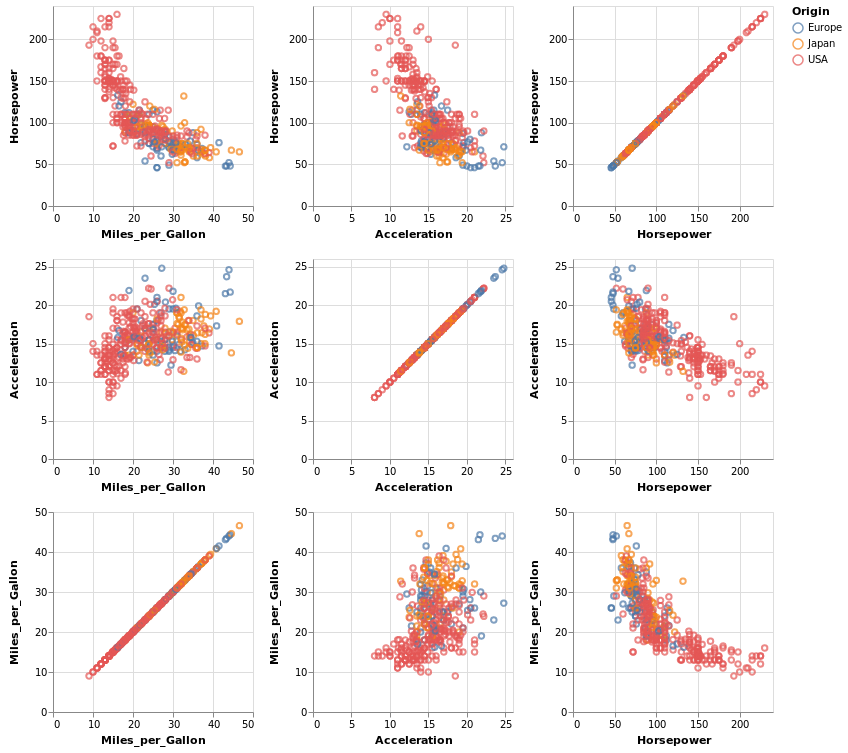

In [54]:
interactiveSplom =
    let rpt = repeat [ RowFields ["Horsepower", "Acceleration", "Miles_per_Gallon"]
                     , ColumnFields ["Miles_per_Gallon", "Acceleration", "Horsepower"]
                     ]
    
        dvals = dataFromUrl "data/cars.json" []
        
        shiftEvent f = (if f then "" else "!") <> "event.shiftKey"
        transCond f = Translate ("[mousedown[" <> shiftEvent f <> "], window:mouseup] > window:mousemove!")
        zoomCond f = Zoom ("wheel![" <> shiftEvent f <> "]")
        sel = selection
                . select "brush" Interval [ ResolveSelections Union
                                          , On "[mousedown[event.shiftKey], window:mouseup] > window:mousemove!"
                                          , transCond True
                                          , zoomCond True
                                          ]
                . select "grid" Interval [ ResolveSelections Global
                                         , BindScales
                                         , transCond False
                                         , zoomCond False
                                         ]
        
        enc = encoding
                . position X [PRepeat Column, PmType Quantitative]
                . position Y [PRepeat Row, PmType Quantitative, PAxis [AxMinExtent 30]]
                . color [ MSelectionCondition (SelectionName "brush")
                                              [MName "Origin", MmType Nominal]
                                              [MString "grey"]
                        ]
                
        layer = [dvals, mark Point [], enc [], sel []]
        
    in toVegaLite [rpt, specification (asSpec layer)]
    
vlShow interactiveSplom

In [55]:
validate interactiveSplomSpec interactiveSplom

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Interactive Dashboard with Cross Highlight

From https://vega.github.io/vega-lite/examples/interactive_concat_layer.html

In [56]:
interactiveConcatLayerSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "A dashboard with cross-highlighting.",
  "data": {"url": "data/movies.json"},
  "vconcat": [
    {
      "layer": [{
        "mark": "rect",
        "encoding": {
          "x": {
            "bin": {"maxbins": 10},
            "field": "IMDB_Rating",
            "type": "quantitative"
          },
          "y": {
            "bin": {"maxbins": 10},
            "field": "Rotten_Tomatoes_Rating",
            "type": "quantitative"
          },
          "color": {
            "aggregate": "count",
            "type": "quantitative",
            "legend": {
              "title": "All Movies",
              "direction": "horizontal",
              "gradientLength": 120
            }
          }
        }
      }, {
        "transform": [{
          "filter": {"selection": "pts"}
        }],
        "mark": "point",
        "encoding": {
          "x": {
            "bin": {"maxbins": 10},
            "field": "IMDB_Rating",
            "type": "quantitative"
          },
          "y": {
            "bin": {"maxbins": 10},
            "field": "Rotten_Tomatoes_Rating",
            "type": "quantitative"
          },
          "size": {
            "aggregate": "count",
            "type": "quantitative",
            "legend": {
              "title": "In Selected Category"
            }
          },
          "color": {
            "value": "#666"
          }
        }
      }]
    }, {
      "width": 330,
      "height": 120,
      "mark": "bar",
      "selection": {
        "pts": {"type": "single", "encodings": ["x"]}
      },
      "encoding": {
        "x": {"field": "Major_Genre", "type": "nominal", "axis": {"labelAngle": -40}},
        "y": {"aggregate": "count", "type": "quantitative"},
        "color": {
          "condition": {
            "selection": "pts",
            "value": "steelblue"
          },
          "value": "grey"
        }
      }
    }
  ],
  "resolve": {
    "legend": {
      "color": "independent",
      "size": "independent"
    }
  }
}
|]

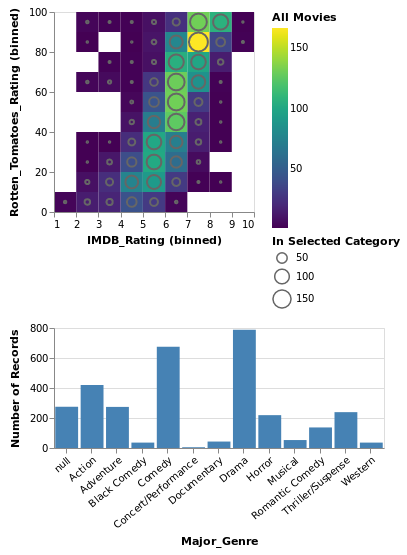

In [57]:
interactiveConcatLayer =
    let dvals = dataFromUrl "data/movies.json" []
        desc = description "A dashboard with cross-highlighting."
        rslv = resolve (resolution (RLegend [(ChColor, Independent), (ChSize, Independent)]) [])

        posOpts name = [PName name, PmType Quantitative, PBin [MaxBins 10]]
        xpos = position X (posOpts "IMDB_Rating")
        ypos = position Y (posOpts "Rotten_Tomatoes_Rating")

        enc1 = encoding
                 . xpos
                 . ypos
                 . color [ MAggregate Count
                         , MmType Quantitative
                         , MLegend [LTitle "All Movies", LDirection Horizontal, LGradientLength 120]
                         ]

        trans2 = transform (filter (FSelection "pts") [])
        enc2 = encoding
                  . xpos
                  . ypos
                  . size [ MAggregate Count
                         , MmType Quantitative
                         , MLegend [LTitle "In Selected Category"]
                         ]
                  . color [MString "#666"]
               
        sel3 = selection (select "pts" Single [Encodings [ChX]] [])
        enc3 = encoding
                 . position X [PName "Major_Genre", PmType Nominal, PAxis [AxLabelAngle (-40)]]
                 . position Y [PAggregate Count, PmType Quantitative]
                 . color [ MSelectionCondition (SelectionName "pts")
                                               [MString "steelblue"] [MString "grey"]
                         ]
        
        lyr1 = [mark Rect [], enc1 []]
        lyr2 = [mark Point [], trans2, enc2 []]
        lyr3 = [width 330, height 120, mark Bar [], sel3, enc3 []]
        layers = [layer (map asSpec [lyr1, lyr2])]
        
    in toVegaLite [dvals, desc, rslv, vConcat [asSpec layers, asSpec lyr3]]
    
vlShow interactiveConcatLayer

In [58]:
validate interactiveConcatLayerSpec interactiveConcatLayer

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Seatle Weather Exploration

From https://vega.github.io/vega-lite/examples/interactive_seattle_weather.html

In [59]:
interactiveSeattleWeatherSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "title": "Seattle Weather, 2012-2015",
  "data": {
    "url": "data/seattle-weather.csv"
  },
  "vconcat": [
    {
      "encoding": {
        "color": {
          "condition": {
            "title": "Weather",
            "field": "weather",
            "scale": {
              "domain": ["sun", "fog", "drizzle", "rain", "snow"],
              "range": ["#e7ba52", "#a7a7a7", "#aec7e8", "#1f77b4", "#9467bd"]
            },
            "selection": "brush",
            "type": "nominal"
          },
          "value": "lightgray"
        },
        "size": {
          "title": "Precipitation",
          "field": "precipitation",
          "scale": {"domain": [-1, 50]},
          "type": "quantitative"
        },
        "x": {
          "axis": {"title": "Date", "format": "%b"},
          "field": "date",
          "timeUnit": "monthdate",
          "type": "temporal"
        },
        "y": {
          "axis": {"title": "Maximum Daily Temperature (C)"},
          "field": "temp_max",
          "scale": {"domain": [-5, 40]},
          "type": "quantitative"
        }
      },
      "width": 600,
      "height": 300,
      "mark": "point",
      "selection": {"brush": {"encodings": ["x"], "type": "interval"}},
      "transform": [{"filter": {"selection": "click"}}]
    },
    {
      "encoding": {
        "color": {
          "condition": {
            "field": "weather",
            "scale": {
              "domain": ["sun", "fog", "drizzle", "rain", "snow"],
              "range": ["#e7ba52", "#a7a7a7", "#aec7e8", "#1f77b4", "#9467bd"]
            },
            "selection": "click",
            "type": "nominal"
          },
          "value": "lightgray"
        },
        "x": {"aggregate": "count", "type": "quantitative"},
        "y": {"title": "Weather", "field": "weather", "type": "nominal"}
      },
      "width": 600,
      "mark": "bar",
      "selection": {"click": {"encodings": ["color"], "type": "multi"}},
      "transform": [{"filter": {"selection": "brush"}}]
    }
  ]
}
|]

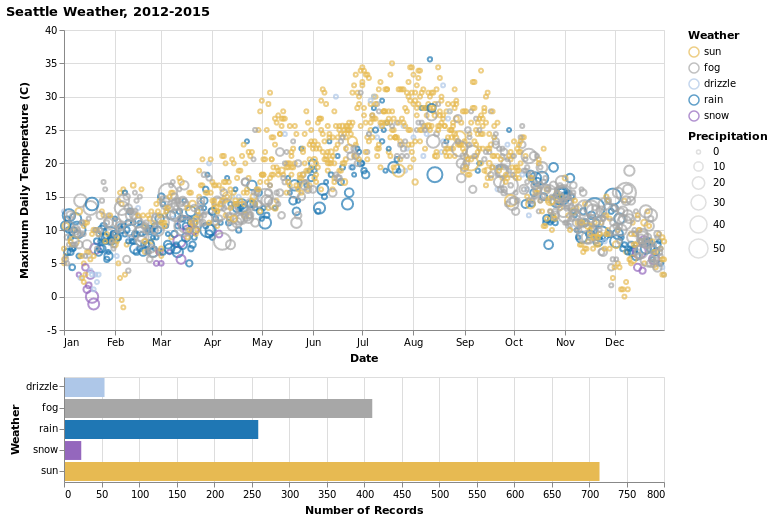

In [60]:
interactiveSeattleWeather =
    let label = title "Seattle Weather, 2012-2015" []
        dvals = dataFromUrl "data/seattle-weather.csv" []
    
        w = width 600

        weatherScale = categoricalDomainMap
                          [ ("sun", "#e7ba52")
                          , ("fog", "#a7a7a7")
                          , ("drizzle", "#aec7e8")
                          , ("rain", "#1f77b4")
                          , ("snow", "#9467bd")
                          ]
        colorSelect name ttl = MSelectionCondition
                                 (SelectionName name)
                                 ([MTitle "Weather" | ttl] ++
                                  [ MName "weather"
                                  , MScale weatherScale
                                  , MmType Nominal
                                  ]
                                 )
                                 [MString "lightgray"]
        enc1 = encoding
                 . position X [ PName "date", PmType Temporal, PTimeUnit MonthDate
                              , PAxis [AxTitle "Date", AxFormat "%b"] ]
                 . position Y [ PName "temp_max", PmType Quantitative
                              , PScale [SDomain (DNumbers [-5, 40])]
                              , PAxis [AxTitle "Maximum Daily Temperature (C)"]
                              ]
                 . color [colorSelect "brush" True]
                 . size [ MName "precipitation", MmType Quantitative
                        , MTitle "Precipitation"
                        , MScale [SDomain (DNumbers [-1, 50])]
                        ]

        enc2 = encoding
                 . position X [PAggregate Count, PmType Quantitative]
                 . position Y [PName "weather", PmType Nominal, PTitle "Weather"]
                 . color [colorSelect "click" False]
                 
        sel1 = selection (select "brush" Interval [Encodings [ChX]] [])
        trans1 = transform (filter (FSelection "click") [])
        
        plot1 = [height 300, w, mark Point [], sel1, trans1, enc1 []]
        
        sel2 = selection (select "click" Multi [Encodings [ChColor]] [])
        trans2 = transform (filter (FSelection "brush") [])
        
        plot2 = [w, mark Bar [], sel2, trans2, enc2 []]
    
        layers = map asSpec [plot1, plot2]
    in toVegaLite [label, dvals, vConcat layers]
    
vlShow interactiveSeattleWeather

In [61]:
validate interactiveSeattleWeatherSpec interactiveSeattleWeather

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Connections among Major U.S. Airports

From https://vega.github.io/vega-lite/examples/airport_connections.html

This is an example where we can not create the exact same specification, but can
create the same visualization.

In [62]:
airportConnectionsSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "description": "An interactive visualization of connections among major U.S. airports in 2008. Based on a U.S. airports example by Mike Bostock.",
  "layer": [
    {
      "mark": {
        "type": "geoshape",
        "fill": "#ddd",
        "stroke": "#fff",
        "strokeWidth": 1
      },
      "data": {
        "url": "data/us-10m.json",
        "format": {"type": "topojson", "feature": "states"}
      }
    },
    {
      "mark": {"type": "rule", "color": "#000", "opacity": 0.35},
      "data": {"url": "data/flights-airport.csv"},
      "transform": [
        {"filter": {"selection": "single"}},
        {
          "lookup": "origin",
          "from": {
            "data": {"url": "data/airports.csv"},
            "key": "iata",
            "fields": ["latitude", "longitude"]
          }
        },
        {
          "lookup": "destination",
          "from": {
            "data": {"url": "data/airports.csv"},
            "key": "iata",
            "fields": ["latitude", "longitude"]
          },
          "as": ["lat2", "lon2"]
        }
      ],
      "encoding": {
        "latitude": {"field": "latitude", "type": "quantitative"},
        "longitude": {"field": "longitude", "type": "quantitative"},
        "latitude2": {"field": "lat2"},
        "longitude2": {"field": "lon2"}
      }
    },
    {
      "mark": {"type": "circle"},
      "data": {"url": "data/flights-airport.csv"},
      "transform": [
        {"aggregate": [{"op": "count", "as": "routes"}], "groupby": ["origin"]},
        {
          "lookup": "origin",
          "from": {
            "data": {"url": "data/airports.csv"},
            "key": "iata",
            "fields": ["state", "latitude", "longitude"]
          }
        },
        {"filter": "datum.state !== 'PR' && datum.state !== 'VI'"}
      ],
      "selection": {
        "single": {
          "type": "single",
          "on": "mouseover",
          "nearest": true,
          "fields": ["origin"],
          "empty": "none"
        }
      },
      "encoding": {
        "latitude": {"field": "latitude", "type": "quantitative"},
        "longitude": {"field": "longitude", "type": "quantitative"},
        "size": {
          "field": "routes",
          "type": "quantitative",
          "scale": {"range": [0, 1000]},
          "legend": null
        },
        "order": {
          "field": "routes",
          "type": "quantitative",
          "sort": "descending"
        }
      }
    }
  ],
  "projection": {"type": "albersUsa"},
  "width": 900,
  "height": 500,
  "config": {"view": {"stroke": null}}
}
|]

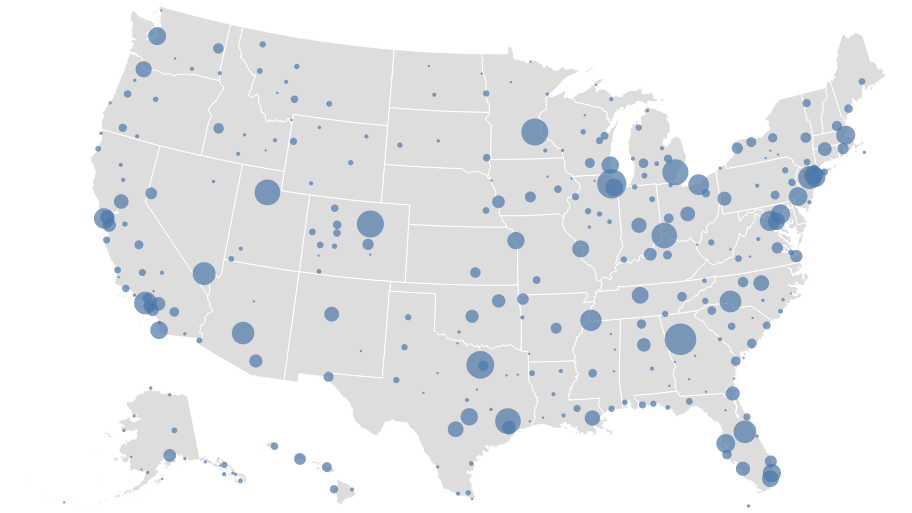

In [63]:
airportConnections =
    let label = description "An interactive visualization of connections among major U.S. airports in 2008. Based on a U.S. airports example by Mike Bostock."

        dvals1 = dataFromUrl "data/us-10m.json" [TopojsonFeature "states"]
        lyr1 = [mark Geoshape [MFill "#ddd", MStroke "#fff", MStrokeWidth 1], dvals1]

        dvals2 = dataFromUrl "data/flights-airport.csv" []
        airport = dataFromUrl "data/airports.csv" []
        
        latPos = position Latitude [PName "latitude", PmType Quantitative]
        lonPos = position Longitude [PName "longitude", PmType Quantitative]
        
        -- We can not directly map to the input specification with lookupAs,
        -- but instead use it to rename the data and then grab the renamed
        -- columns in the encoding instead. See
        -- https://github.com/gicentre/elm-vegalite/issues/14
        --
        trans2 = transform
                   . filter (FSelection "single")
                   . lookup "origin" airport "iata" ["latitude", "longitude"]
                   . lookupAs "destination" airport "iata" "dest"
        enc2 = encoding
                 . latPos
                 . lonPos
                 . position Latitude2 [PName "dest.latitude"]
                 . position Longitude2 [PName "dest.longitude"]
        lyr2 = [mark Rule [MColor "#000", MOpacity 0.35], dvals2, trans2 [], enc2 []]

        trans3 = transform
                   . aggregate [opAs Count "" "routes"] ["origin"]
                   . lookup "origin" airport "iata" ["state", "latitude", "longitude"]
                   . filter (FExpr "datum.state !== 'PR' && datum.state !== 'VI'")
        sel3 = selection
                  (select "single" Single
                          [On "mouseover", Nearest True, Fields ["origin"], Empty]
                          [])
                          
        enc3 = encoding
                 . latPos
                 . lonPos
                 . size [MName "routes", MmType Quantitative, MScale [SRange (RNumbers [0, 1000])], MLegend []]
                 . order [OName "routes", OmType Quantitative, OSort [Descending]]

        lyr3 = [mark Circle [], dvals2, trans3 [], sel3, enc3 []]
        
        lyr = layer (map asSpec [lyr1, lyr2, lyr3])
    
        proj = projection [PrType AlbersUsa]
        cnf = configure (configuration (View [ViewStroke Nothing]) [])
                
    in toVegaLite [label, lyr, proj, width 900, height 500, cnf]
    
vlShow airportConnections

The following differences look significant, but they are mainly due to the limited expressivity of
the `lookupAs` combinator in `hvega`, which means that the functionality of the Vega-Lite
`lookup` definition has to be spread between the `hvega` `lookupAs` and `position` functions.

The remaining difference is a syntactic, not semantic one: `hvega` simplifies the output of
`mark Circle []` whereas in this example the Vega-Lite specification uses a longer form (they
have the same meaning).

In [64]:
validate airportConnectionsSpec airportConnections

The visualization and expected specification do not match.

Values are different for "layer"
  Expected: Array [Object (fromList [("mark",Object (fromList [("strokeWidth",Number 1.0),("stroke",String "#fff"),("fill",String "#ddd"),("type",String "geoshape")])),("data",Object (fromList [("url",String "data/us-10m.json"),("format",Object (fromList [("feature",String "states"),("type",String "topojson")]))]))]),Object (fromList [("transform",Array [Object (fromList [("filter",Object (fromList [("selection",String "single")]))]),Object (fromList [("from",Object (fromList [("data",Object (fromList [("url",String "data/airports.csv")])),("key",String "iata"),("fields",Array [String "latitude",String "longitude"])])),("lookup",String "origin")]),Object (fromList [("as",Array [String "lat2",String "lon2"]),("from",Object (fromList [("data",Object (fromList [("url",String "data/airports.csv")])),("key",String "iata"),("fields",Array [String "latitude",String "longitude"])])),("lookup",String "d

Return to the [Table of Contents](#Table-of-Contents).